In [1]:
import gym

env = gym.vector.make("CartPole-v1", num_envs=4, asynchronous=True)
env.seed(0)

In [2]:
from a2c import A2C
from shared_a2c import SharedA2C

actor = SharedA2C(env.single_observation_space, env.single_action_space)

In [3]:
import time
import math
import numpy as np

def train(agent, env, total_timesteps, break_condition):
    total_rewards = [[] for _ in range(env.num_envs)]
    avg_total_rewards = []

    total_reward = np.zeros(env.num_envs)
    observations = env.reset()
    timestep = 0
    episode = 0

    t = 0
    
    start_time = time.time()

    while timestep < total_timesteps:
        actions = agent.act(observations)
        next_observations, rewards, dones, _ = env.step(actions)
        agent.remember(observations, actions, rewards, next_observations, dones)
        agent.train()
        
        timestep += len(observations)
        t += 1

        total_reward += rewards

        for i in range(env.num_envs):
            if dones[i]:
                total_rewards[i].append((t, timestep, total_reward[i]))
                episode += 1

        if any(G for G in total_rewards):
            episode_returns = sorted(
                list(np.concatenate([G for G in total_rewards if G])),
                key=lambda x: x[1]
            )

            avg_total_rewards.append(
                (t, timestep, np.mean([G[-1] for G in episode_returns[-20:]]))
            )

        total_reward *= 1 - dones
        observations = next_observations

        ratio = math.ceil(100 * timestep / total_timesteps)
        uptime = math.ceil(time.time() - start_time)

        avg_return = avg_total_rewards[-1][-1] if avg_total_rewards else np.nan

        print(f"[{ratio:3d}% / {uptime:3d}s] timestep = {timestep}/{total_timesteps}, episode = {episode:3d}, avg_return = {avg_return:10.4f}\r", end="")

        if avg_return > break_condition:
            return avg_total_rewards

    return avg_total_rewards

In [4]:
returns = train(actor, env, 100000, break_condition=450)

In [5]:
import imageio
import numpy as np

def evaluate(agent, env, n_episodes=5, render=False, record=False):
    images = []
    for episode in range(n_episodes):
        obs = env.reset()        
        total_reward = 0.0
        episode_length = 0

        done = False
        while not done:
            action = agent.act(obs.reshape(1, *obs.shape))
            next_obs, reward, done, _ = env.step(action[0])
            obs = next_obs
            
            total_reward += reward
            episode_length += 1

            if render:
                env.render()
            if record:
                images.append(env.render(mode='rgb_array'))
        
        if render:
            env.close()

        print(f">> episode = {episode + 1} / {n_episodes}, total_reward = {total_reward:10.4f}, episode_length = {episode_length}")
        
    if record:
        imageio.mimsave('../img/CartPoleA2C.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

In [6]:
eval_env = gym.make("CartPole-v1")
evaluate(actor, eval_env, 1, True, False)

>> episode = 1 / 1, total_reward =   500.0000, episode_length = 500


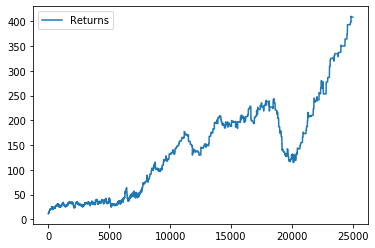

In [7]:
import matplotlib.pyplot as plt

rewards = np.transpose(returns)[2]
plt.plot(range(len(rewards)), rewards, label='Returns')
plt.legend()
plt.show()